## Problem Statement:

The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from various policy documents.
We are given set of life insurance documents. Our purpose is to build a RAG application for efficient searching in the documents with LlamaIndex.

#### Insurance domain + Build the RAG pipeline using llamaindex.

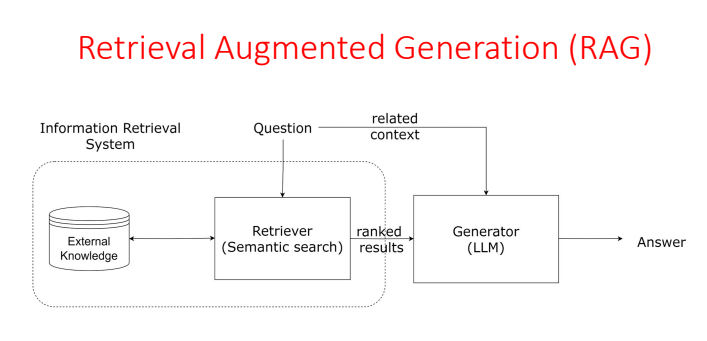

Without RAG: LLM's don't have any information on the domain/enterprise specific query.

Using RAG We are can connect an external data ingested & transformed embeddings into vectorDB. We can peform Semantic search or say dot product or cosine similarity and return top k relevant documents. We can then pass this return context along with user query using decorated prompt engineering to llm to repspond to user query from domain specific docs say here insurance documents.

RAG also helps to cache the latest query and answer in cache. If check in similary query present in cache if yes return from cache. If not found in cache then perform semantic search and using context check with llm for query. results in cache return from cache from save usig past coversation else perfrom sematic search search in vector with top k context generate the response usign llm.

RAG also helps in overcoming the problem of fixed token size issues with Llm and hallucination.

### RAG
**Retrieval-Augmented Generation** (RAG) is a method that improves the responses of a language model by using information from a knowledge base. It's like giving the model a library of information to reference when it's generating a response. This makes the model's responses more accurate and relevant.

RAG combines two types of models:
- ***retrieval models***, which pull data from a knowledge base, and
- ***generative models*** , which create the responses.

This combination makes RAG more powerful than a model that only generates responses. It can answer difficult questions and provide more informative responses.

### LlamaIndex
**LlamaIndex** is a framework for building context-augmented LLM applications. Context augmentation refers to any use case that applies LLMs on top of your private or domain-specific data.

Some popular use cases include the following:
* Question-Answering Chatbots (commonly referred to as RAG, or "Retrieval-Augmented Generation")
* Document Understanding and Extraction
* Autonomous Agents that can perform research and take actions

LlamaIndex provides the tools to build any of these above use cases from prototype to production. The tools allow you to ingest and process this data and implement complex queries. It combines data access with LLM prompting.

To install the library:

`pip install llama-index`

### Part 1 - Overall Product Specifications

***Problem Statement*** - Build a robust generative search system capable of effectively and accurately answering questions from a list of HDFC Insurance policy documents.

***Solution Strategy*** - Build a solution which should solve the following requirements:

- Users would responses from insurance policy knowledge base.
- If user want to perform a query system must be able to response to query accurately.

***Goal*** - Solving the above two requirements well in and would ensure that the accuracy of the overall model is good.

***Data Used*** -HDFC Insuracne policy documetns sotred in single folder

***Tools used*** - LlamaIndex, ChatGPT has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

## Part 2 - Solution

In this section, we go ahead and actually build the solution that we proposed in the previous step.

### Import the necessary libraries

In [1]:
## While installing LlamaIndex, you can specify the version to install. We are installing version `v0.10.34`, which was the latest release version at the time of writing this notebook.
%pip install llama-index==0.10.34

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Document loaders for SimpleDirectoryReader
!pip install docx2txt
!pip install pypdf

# Install OpenAI
!pip install openai


In [3]:
#import openAI
from llama_index.llms.openai import OpenAI
#import ChatMessage
from llama_index.core.llms import ChatMessage
#import os
import os
import openai

In [4]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [5]:
#Set API key
filepath="API_Key/"
with open(filepath + "Api Key.txt","r") as f:
  openai.api_key=''.join(f.readlines())

### Data Loading


***2 ways to do this***

- If you have a single file containing all the required data, use a data loader from [LLamahub](https://llamahub.ai/)

- If you have multiple files, use *Simple Directory Reader* Just ensure that for reading each file type the necessary dependency libraries are already installed.

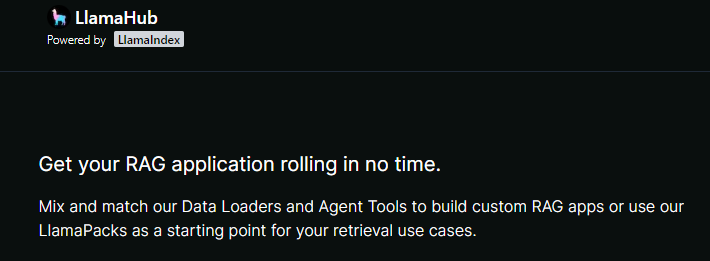

In [6]:
#import SimpleDirectoryReader
from llama_index.core import SimpleDirectoryReader

# Create object of SimpleDirectoryReader
reader=SimpleDirectoryReader(input_dir="data/Policy_documents")

In [7]:
documents=reader.load_data()
#lenth of documents
print(f"Loaded {len(documents)} documents/pages successfully.")

Loaded 121 documents/pages successfully.


In [8]:
documents[0]

Document(id_='e0a2b00e-0b44-42f2-a169-61a7c9ccde63', embedding=None, metadata={'page_label': '1', 'file_name': 'Copy of HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_path': 'C:\\Users\\khaneja\\Documents\\Personal\\Upgrad\\Module 38 - Semantic Spotter\\Tarun\\data\\Policy_documents\\Copy of HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_type': 'application/pdf', 'file_size': 1303156, 'creation_date': '2024-10-20', 'last_modified_date': '1980-01-01'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \n             Part A \n<<Date>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>>  \n \nDear <<Policyholder’s Name>>,  \n \nSub: Your Policy no. <<  >> \nWe are glad to infor

### Core Components Of LlamaIndex

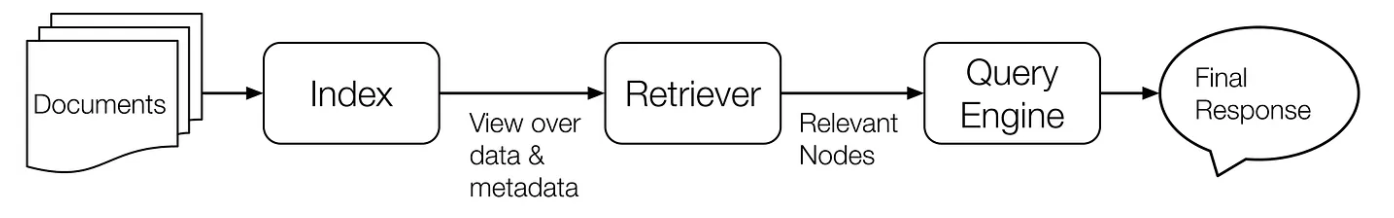

#### Documents and Nodes
Documents in LlamaIndex may be different from your traditional perception of documents. <br>
Document and Node objects are core abstractions within LlamaIndex.

A **Document** is a generic container around any data source - for instance, a PDF, an API output, or retrieved data from a database. They can be constructed manually, or created automatically via data loaders. By default, a Document stores text along with some other attributes. Some of these are

`metadata` - a dictionary of annotations that can be appended to the text (basically, additional info about the document) <br>
`relationships` - a dictionary containing relationships to other Documents/Nodes.

<br>

A **Node** represents a "chunk" of a source Document, whether that is a text chunk, an image, or other. Similar to Documents, they contain metadata and relationship information with other nodes.

Nodes are a first-class citizen in LlamaIndex. You can choose to define Nodes and all its attributes directly. You may also choose to "parse" source Documents into Nodes through our `NodeParser` classes. By default every Node derived from a Document will inherit the same metadata from that Document (e.g. a "file_name" filed in the Document is propagated to every Node).

Both Documents and Nodes have unique identifies called `ID`. These can be set automatically or manually. `ID` is generally used to identify, update, and define relationships between documents (or nodes).


## Building the query engine

In [9]:
# import SimpleNodeParser
from llama_index.core.node_parser import SimpleNodeParser

# import VectorStoreIndex
from llama_index.core import VectorStoreIndex

# import display, HTML
from IPython.display import display, HTML

# Create parser and parse docuemnts into nodes
parser=SimpleNodeParser.from_defaults()
nodes=parser.get_nodes_from_documents(documents)

# build index
index=VectorStoreIndex(nodes)

#construct query engine
query_engine=index.as_query_engine()


In [10]:
# Query
response = query_engine.query("what will happen if If Nominee(s) die after the Policyholder but before his share of the amount secured under the Policy is paid?")

In [11]:
response.response

'The share of the expired nominee(s) will be payable to the heirs or legal representative of the nominee or holder of succession certificate of such nominee(s).'

In [12]:
dir(response)

['__annotations__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get_validators__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__pydantic_initialised__',
 '__pydantic_model__',
 '__pydantic_run_validation__',
 '__pydantic_validate_values__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__validate__',
 '__weakref__',
 'get_formatted_sources',
 'metadata',
 'response',
 'source_nodes']

In [13]:
response.metadata

{'a5a6c7cc-cf66-4db1-9e09-93db44cd62bf': {'page_label': '24',
  'file_name': 'Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf',
  'file_path': 'C:\\Users\\khaneja\\Documents\\Personal\\Upgrad\\Module 38 - Semantic Spotter\\Tarun\\data\\Policy_documents\\Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf',
  'file_type': 'application/pdf',
  'file_size': 721038,
  'creation_date': '2024-10-20',
  'last_modified_date': '1980-01-01'},
 '507eaccb-c01b-4f3c-84ba-9ab326371a8e': {'page_label': '25',
  'file_name': 'Copy of HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf',
  'file_path': 'C:\\Users\\khaneja\\Documents\\Personal\\Upgrad\\Module 38 - Semantic Spotter\\Tarun\\data\\Policy_documents\\Copy of HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf',
  'file_type': 'application/pdf',
  'file_size': 1371541,
  'creation_date': '2024-10-20',
  'last_modified_date': '1980-01-01'}}

In [14]:
response.source_nodes

[NodeWithScore(node=TextNode(id_='a5a6c7cc-cf66-4db1-9e09-93db44cd62bf', embedding=None, metadata={'page_label': '24', 'file_name': 'Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'file_path': 'C:\\Users\\khaneja\\Documents\\Personal\\Upgrad\\Module 38 - Semantic Spotter\\Tarun\\data\\Policy_documents\\Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'file_type': 'application/pdf', 'file_size': 721038, 'creation_date': '2024-10-20', 'last_modified_date': '1980-01-01'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4c47a7e6-3109-45f2-a881-7d710dd22ecd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '24', 'file_n

In [15]:
len(response.source_nodes)

2

In [16]:
print(response.source_nodes[0].node.metadata['file_name'])
print(response.source_nodes[0].node.metadata['page_label'])

Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
24


In [17]:
print(response.source_nodes[0].node.metadata['file_name'] + " Page No " + response.source_nodes[0].node.metadata['page_label'])

Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf Page No 24


In [18]:
# Extract the score
print(response.source_nodes[0].score)

0.8898810048824223


In [19]:
# Response Node Text
response.source_nodes[0].node.text

'14) If nominee(s) die after the policyholder but before his share of the amount secured under the policy is paid, \nthe share of the expired nominee(s) shall be payable to the heirs or legal representative of the nominee or \nholder o f succession certificate of such nominee(s).  \n15) The provisions of sub -section 7 and 8 (13 and 14 above) shall apply to all life insurance policies maturing for \npayment after the commencement of Insurance Laws (Amendment) Act, 2015 (i.e. 23.03.2015).     \n16) If policyholder dies after maturity but the proceeds and benefit of the policy has not been paid to him because \nof his death, his nominee(s) shall be entitled to the proceeds and benefit of the policy.  \n17) The provisions of Section 39 are not applicable to any li fe insurance policy to which Section 6 of Married \nWomen’s Property Act, 1874 applies or has at any time applied except where before or  after Insurance Laws \n(Amendment) Act, 2015, a nomination is made in favour of spouse or 

## Creating response pipeline

In [20]:
# Query response function
def query_response(user_input):
  response=query_engine.query(user_input)
  file_name=response.source_nodes[0].node.metadata['file_name'] + " Page No " + response.source_nodes[0].node.metadata['page_label'] + '<br> Similarity score is :' + str(response.source_nodes[0].score)
  final_response=response.response + "<br> Check further at " + file_name
  return final_response

In [22]:
def initialize_conv():
  print("Feel free to ask questions related to insurance policies. Enter exit to finish the conversation!!")
  while True:
    user_input=input()
    if user_input.lower() == "exit":
      print("Exiting the program. Exited!!!")
      break
    else:
      response=query_response(user_input)
      display(HTML(f'<p style="font-size:20px">{response}</p>'))

In [23]:
initialize_conv()

Feel free to ask questions related to insurance policies. Enter exit to finish the conversation!!
when a person can receive the claims?


Can you suggest one term insurance plan?


who is eligible member in the context of insurance policy?


exit
Exiting the program. Exited!!!


## Building a test pipeline

In [24]:
# Definig the user query.
questions = ['What is beneficiary in HDFC insurance policy',
             'Which is company name is talking about in provided context?',
             'Who is eligible member in the context of insurance policy?',
             'When a person can recieve the claims?']

In [25]:
import pandas as pd

def testing_pipeline(questions):
  test_feedback=[]
  for i in questions:
    print(i)
#     print(query_response(i))
    display(HTML(f'<p style="font-size:20px">{query_response(i)}</p>'))
    print("\nPlease provide your feedback on the response provided by bot")
    user_input=input()
    page=query_response(i).split()[-1]
    test_feedback.append((i,query_response(i),page,user_input))

  feedback_df=pd.DataFrame(test_feedback,columns=["Question","Response","Page","Good/Bad"])
  return feedback_df

In [26]:
testing_pipeline(questions)

What is beneficiary in HDFC insurance policy



Please provide your feedback on the response provided by bot
good
Which is company name is talking about in provided context?



Please provide your feedback on the response provided by bot
good
Who is eligible member in the context of insurance policy?



Please provide your feedback on the response provided by bot
good
When a person can recieve the claims?



Please provide your feedback on the response provided by bot
good


,Question,Response,Page,Good/Bad
0,What is beneficiary in HDFC insurance policy,The beneficiary in HDFC insurance policy is th...,:0.8504116368845972,good
1,Which is company name is talking about in prov...,HDFC Life<br> Check further at Copy of HDFC-Li...,:0.757921216090719,good
2,Who is eligible member in the context of insur...,An eligible member in the context of the insur...,:0.8787312173092846,good
3,When a person can recieve the claims?,A person can receive the claims after submitti...,:0.8206031103341381,good


### Part 3: Next steps

### Building a custom prompt template

In [34]:
response=query_engine.query("what will happen if If Nominee(s) die after the Policyholder but before his share of the amount secured under the Policy is paid?")

In [35]:
response.response

'The share of the expired nominee(s) will be payable to the heirs or legal representative of the nominee or holder of succession certificate of such nominee(s).'

In [36]:
# response source nodes

response.source_nodes

[NodeWithScore(node=TextNode(id_='a5a6c7cc-cf66-4db1-9e09-93db44cd62bf', embedding=None, metadata={'page_label': '24', 'file_name': 'Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'file_path': 'C:\\Users\\khaneja\\Documents\\Personal\\Upgrad\\Module 38 - Semantic Spotter\\Tarun\\data\\Policy_documents\\Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'file_type': 'application/pdf', 'file_size': 721038, 'creation_date': '2024-10-20', 'last_modified_date': '1980-01-01'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4c47a7e6-3109-45f2-a881-7d710dd22ecd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '24', 'file_n

In [37]:
response.source_nodes[0]

NodeWithScore(node=TextNode(id_='a5a6c7cc-cf66-4db1-9e09-93db44cd62bf', embedding=None, metadata={'page_label': '24', 'file_name': 'Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'file_path': 'C:\\Users\\khaneja\\Documents\\Personal\\Upgrad\\Module 38 - Semantic Spotter\\Tarun\\data\\Policy_documents\\Copy of HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf', 'file_type': 'application/pdf', 'file_size': 721038, 'creation_date': '2024-10-20', 'last_modified_date': '1980-01-01'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='4c47a7e6-3109-45f2-a881-7d710dd22ecd', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'page_label': '24', 'file_na

In [31]:
response.source_nodes[1].node.text

'Page 15 of 31 \n  \nNote: For the purpose of waiting period, Date of commencement or inception of coverage for a benefit option \nshall mean the date from which the member is covered under that benefit option. \n \niv. Accidental Death Benefit Exclusions: \n1. No Accidental Death Benefit will be payable if the death of the Scheme Members occurs after 180 days \nfrom the date of Accident. \nSpecific Exclusions for this benefit are listed below \nWe will not pay Accidental Death Benefit, if Accidental Death is caused from or due to  any of the \nfollowing:  \n\uf0b7 Intentionally self-inflicted injury or suicide while sane or insane \n\uf0b7 Alcohol or Solvent abuse or taking of Drugs, narcotics or psychotropic substances unless taken in \naccordance with the lawful directions and prescription of a registered medical practitioner. \n\uf0b7 Engaging in or taking part in professional sport(s) or any hazardous pursuits, power boat racing, sky \ndiving, para gliding, parachuting, scuba divi

In [38]:
reference_0 = " Check further at " + response.source_nodes[0].node.metadata['file_name'] + " Page No " + response.source_nodes[0].node.metadata['page_label']
reference_1 = " Check further at " + response.source_nodes[1].node.metadata['file_name'] + " Page No " + response.source_nodes[1].node.metadata['page_label']
retrieved = response.source_nodes[0].node.text + reference_0 + response.source_nodes[1].node.text + reference_1
retrieved

'14) If nominee(s) die after the policyholder but before his share of the amount secured under the policy is paid, \nthe share of the expired nominee(s) shall be payable to the heirs or legal representative of the nominee or \nholder o f succession certificate of such nominee(s).  \n15) The provisions of sub -section 7 and 8 (13 and 14 above) shall apply to all life insurance policies maturing for \npayment after the commencement of Insurance Laws (Amendment) Act, 2015 (i.e. 23.03.2015).     \n16) If policyholder dies after maturity but the proceeds and benefit of the policy has not been paid to him because \nof his death, his nominee(s) shall be entitled to the proceeds and benefit of the policy.  \n17) The provisions of Section 39 are not applicable to any li fe insurance policy to which Section 6 of Married \nWomen’s Property Act, 1874 applies or has at any time applied except where before or  after Insurance Laws \n(Amendment) Act, 2015, a nomination is made in favour of spouse or 

In [39]:
messages=[
          {
              "role":"system",
              "content":"You are AI assistent to user."
          },
          {
              "role":"user",
              "content": f"""what will happen if If Nominee(s) die after the Policyholder but before his share of the amount secured under the Policy is paid? Check in '{retrieved}'
              """
          }
        ]
messages

[{'role': 'system', 'content': 'You are AI assistent to user.'},
 {'role': 'user',
  'content': "what will happen if If Nominee(s) die after the Policyholder but before his share of the amount secured under the Policy is paid? Check in '14) If nominee(s) die after the policyholder but before his share of the amount secured under the policy is paid, \nthe share of the expired nominee(s) shall be payable to the heirs or legal representative of the nominee or \nholder o f succession certificate of such nominee(s).  \n15) The provisions of sub -section 7 and 8 (13 and 14 above) shall apply to all life insurance policies maturing for \npayment after the commencement of Insurance Laws (Amendment) Act, 2015 (i.e. 23.03.2015).     \n16) If policyholder dies after maturity but the proceeds and benefit of the policy has not been paid to him because \nof his death, his nominee(s) shall be entitled to the proceeds and benefit of the policy.  \n17) The provisions of Section 39 are not applicable to

In [40]:
response2=openai.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=messages
)
response2.choices[0].message.content

"If a nominee(s) dies after the policyholder but before his share of the amount secured under the policy is paid, the share of the expired nominee(s) shall be payable to the heirs or legal representative of the nominee or holder of succession certificate of such nominee(s). This provision applies to all life insurance policies maturing for payment after the commencement of Insurance Laws (Amendment) Act, 2015. \n\nIn addition, if the policyholder dies after maturity but the proceeds and benefit of the policy has not been paid to him because of his death, his nominee(s) shall be entitled to the proceeds and benefit of the policy.\n\nIt's important for policyholders to refer to the complete and accurate details of the Insurance Laws (Amendment) Act, 2015 for further information and understanding."

### Recommendations on How to improve further



*   Based on testing pipeline's feedback, develop a strategy how to improve it further


*   This can be done thorough building a better/cleaner dataset or utilizing better data pre-processing techniques
   



#### Suggestion 1: Using customized nodes and LLMs

This can be used if responses are not accurate or is not being summarized very well

In [41]:
#import OpenAIEmbedding
from llama_index.embeddings.openai import OpenAIEmbedding
#import SentenceSplitter
from llama_index.core.node_parser import SentenceSplitter
#import OpenAI
from llama_index.llms.openai import OpenAI
#import Settings
from llama_index.core import Settings

#Initialize the openAI model
Settings.lm=OpenAI(model="gpt-3.5-turbo", temperature=0, max_tokens=256)

#Initialize the embedding model
Settings.embed_model=OpenAIEmbedding()

#Initialize the node_parser with custom node settings
Settings.node_parser=SentenceSplitter(chunk_size=512, chunk_overlap=20)

# Initialize the num_output and context window
Settings.num_output=512
Settings.context_window=3900

#Create a VectorStoreIndex from a list of documents using the service context
index=VectorStoreIndex.from_documents(documents)

# Initialize a query engine for the index with a specified similiarity with top-k values
query_engine=index.as_query_engine(similarity_top_k=3)


In [42]:
#Query the engine with specific question

response=query_engine.query("""what will happen if If Nominee(s) die after the Policyholder but before his share of the amount secured under the Policy is paid?""")

In [43]:
response.response

'The share of the expired nominee(s) shall be payable to the heirs or legal representative of the nominee or holder of succession certificate of such nominee(s).'